# Smart Queue Monitoring System - Retail Scenario

## Overview
Now that you have your Python script and job submission script, you're ready to request an edge node and run inference on the different hardware types (CPU, GPU, VPU, FPGA).

After the inference is completed, the output video and stats files need to be retrieved and stored in the workspace, which can then be viewed within the Jupyter Notebook.

## Objectives
* Submit inference jobs to Intel's DevCloud using the `qsub` command.
* Retrieve and review the results.
* After testing, go back to the proposal doc and update your original proposed hardware device.

## Step 0: Set Up

#### IMPORTANT: Set up paths so we can run Dev Cloud utilities
You *must* run this every time you enter a Workspace session.
(Tip: select the cell and use **Shift+Enter** to run the cell.)

In [8]:
%env PATH=/opt/conda/bin:/opt/spark-2.4.3-bin-hadoop2.7/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/opt/intel_devcloud_support
import os
import sys
sys.path.insert(0, os.path.abspath('/opt/intel_devcloud_support'))
sys.path.insert(0, os.path.abspath('/opt/intel'))

env: PATH=/opt/conda/bin:/opt/spark-2.4.3-bin-hadoop2.7/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/opt/intel_devcloud_support


In [27]:
MODEL_PATH = '/data/models/intel/person-detection-retail-0013/FP16/person-detection-retail-0013'
VIDEO = '/data/resources/retail.mp4'
QUEUE = '/data/queue_param/retail.npy'
PEOPLE = 5

import liveQStat
import videoHtml
import get_results

def device_decoder(device):
    device_postfix = device
    if device.startswith('HETERO:FPGA'):
        device_postfix = 'FPGA'
    if device.startswith('MYRIAD'):
        device_postfix = 'VPU'
    return device, device_postfix, device_postfix.lower()


def submit(device, node):
    device, device_postfix, device_postfix_l = device_decoder(device)
    job_name = 'JOB_RETAIL_' + device_postfix
    output = '/output/results/retail/' + device_postfix.lower()
    params = '{} {} {} {} {} {}'.format(MODEL_PATH, device, VIDEO, QUEUE, output, PEOPLE)
    job_id = !qsub queue_job.sh -l nodes=1:{node} -d . -F "{params}" -N {job_name}
    return job_id


def process_results(device, xyz_job_id):
    device, device_postfix, device_postfix_l = device_decoder(device)
    video_title = 'Retail ' + device_postfix
    output_video = 'results/retail/' + device_postfix_l + '/output_video.mp4'
    liveQStat.liveQStat()
    get_results.getResults(xyz_job_id, filename='output.tgz', blocking=True)
    !tar zxf output.tgz
    #!cat stdout.log
    !cat stderr.log
    return video_title, [output_video]

### Step 0.1:  (Optional-step): Original Video

If you are curious to see the input video, run the following cell to view the original video stream we'll be using for inference.

In [10]:
import videoHtml
videoHtml.videoHTML('Retail', ['original_videos/Retail.mp4'])

## Step 1 : Inference on a Video

In the next few cells, You'll submit your job using the `qsub` command and retrieving the results for each job. Each of the cells below should submit a job to different edge compute nodes.

The output of the cell is the `JobID` of your job, which you can use to track progress of a job with `liveQStat`.

You will need to submit a job for each of the following hardware types:
* **CPU**
* **GPU**
* **VPU**
* **FPGA**

**Note** You will have to submit each job one at a time and retrieve their results. 

After submission, they will go into a queue and run as soon as the requested compute resources become available. 
(Tip: **shift+enter** will run the cell and automatically move you to the next cell.)

If your job successfully runs and completes, once you retrieve your results, it should output a video and a stats text file in the `results/retail/<DEVICE>` directory.

For example, your **CPU** job should output its files in this directory:
> **results/retail/cpu**

**Note**: To get the queue labels for the different hardware devices, you can go to [this link](https://devcloud.intel.com/edge/get_started/devcloud/).

The following arguments should be passed to the job submission script after the `-F` flag:
* Model path - `/data/models/intel/person-detection-retail-0013/<MODEL PRECISION>/`. You will need to adjust this path based on the model precision being using on the hardware.
* Device - `CPU`, `GPU`, `MYRIAD`, `HETERO:FPGA,CPU`
* Manufacturing video path - `/data/resources/retail.mp4`
* Manufacturing queue_param file path - `/data/queue_param/retail.npy`
* Output path - `/output/results/retail/<DEVICE>` This should be adjusted based on the device used in the job.
* Max num of people - This is the max number of people in queue before the system would redirect them to another queue.

## Step 1.1: Submit to an Edge Compute Node with an Intel CPU
In the cell below, write a script to submit a job to an edge node with an <a 
    href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel® Core™ i5-6500TE processor</a>. The inference workload should run on the CPU.

In [11]:
#Submit job to the queue
cpu_job_id = submit('CPU', 'tank-870:i5-6500te')
print(cpu_job_id[0])

tKc80KXyroMXR4AEED2TDLQya4rPRTJM


In [12]:
cpu_title, cpu_video = process_results('CPU', cpu_job_id[0])

getResults() is blocking until results of the job (id:tKc80KXyroMXR4AEED2TDLQya4rPRTJM) are ready.
Please wait...Success!
output.tgz was downloaded in the same folder as this notebook.


In [13]:
videoHtml.videoHTML(cpu_title, cpu_video)

## Step 1.2: Submit to an Edge Compute Node with a CPU and IGPU
In the cell below, write a script to submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel® Core i5-6500TE</a>. The inference workload should run on the **Intel® HD Graphics 530** integrated GPU.

In [14]:
#Submit job to the queue
gpu_job_id = submit('GPU', 'tank-870:i5-6500te:intel-hd-530')
print(gpu_job_id[0])

N656ZfNGW6EhAOmKcr78KWdpRPsAB05M


In [15]:
gpu_title, gpu_video = process_results('GPU', gpu_job_id[0])

getResults() is blocking until results of the job (id:N656ZfNGW6EhAOmKcr78KWdpRPsAB05M) are ready.
Please wait...................Success!
output.tgz was downloaded in the same folder as this notebook.


In [16]:
videoHtml.videoHTML(gpu_title, gpu_video)

## Step 1.3: Submit to an Edge Compute Node with an Intel® Neural Compute Stick 2
In the cell below, write a script to submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a>. The inference workload should run on an <a 
    href="https://software.intel.com/en-us/neural-compute-stick">Intel Neural Compute Stick 2</a> installed in this  node.

In [17]:
#Submit job to the queue
vpu_job_id = submit('MYRIAD', 'tank-870:i5-6500te:intel-ncs2')
print(vpu_job_id[0])

5x1zq2lZfzAiM16tuMBtIDxU4Z3AQe30


In [18]:
vpu_title, vpu_video = process_results('VPU', vpu_job_id[0])

getResults() is blocking until results of the job (id:5x1zq2lZfzAiM16tuMBtIDxU4Z3AQe30) are ready.
Please wait.....Success!
output.tgz was downloaded in the same folder as this notebook.


In [19]:
videoHtml.videoHTML(vpu_title, vpu_video)

## Step 1.4: Submit to an Edge Compute Node with IEI Mustang-F100-A10
In the cell below, write a script to submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core™ i5-6500te CPU</a> . The inference workload will run on the <a href="https://www.ieiworld.com/mustang-f100/en/"> IEI Mustang-F100-A10 </a> FPGA card installed in this node.

In [20]:
#Submit job to the queue
fpga_job_id = submit('HETERO:FPGA,CPU', 'tank-870:i5-6500te:iei-mustang-f100-a10')
print(fpga_job_id[0])

905oOsPMPOiouRw60VLuL6DldKTCiFaS


In [21]:
fpga_title, fpga_video = process_results('FPGA', fpga_job_id[0])

getResults() is blocking until results of the job (id:905oOsPMPOiouRw60VLuL6DldKTCiFaS) are ready.
Please wait.....Success!
output.tgz was downloaded in the same folder as this notebook.
Couldn't open file /opt/intel/openvino/bitstreams/a10_vision_design_sg2_bitstreams/2020-2_PL2_FP16_MobileNet_Clamp.aocx for reading


In [22]:
videoHtml.videoHTML(fpga_title, fpga_video)

***Wait!***

Please wait for all the inference jobs and video rendering to complete before proceeding to the next step.

## Step 2: Assess Performance

Run the cells below to compare the performance across all 4 devices. The following timings for the model are being comapred across all 4 devices:

- Model Loading Time
- Average Inference Time
- FPS

In [23]:
import matplotlib.pyplot as plt

device_list=['cpu', 'gpu', 'fpga', 'vpu']
inference_time=[]
fps=[]
model_load_time=[]

for device in device_list:
    with open('results/retail/'+device+'/stats.txt', 'r') as f:
        inference_time.append(float(f.readline().split("\n")[0]))
        fps.append(float(f.readline().split("\n")[0]))
        model_load_time.append(float(f.readline().split("\n")[0]))

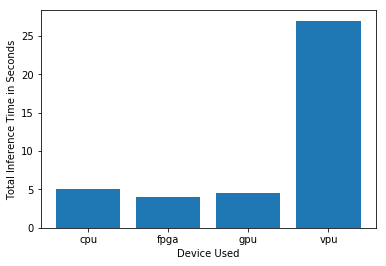

In [24]:
plt.bar(device_list, inference_time)
plt.xlabel("Device Used")
plt.ylabel("Total Inference Time in Seconds")
plt.show()

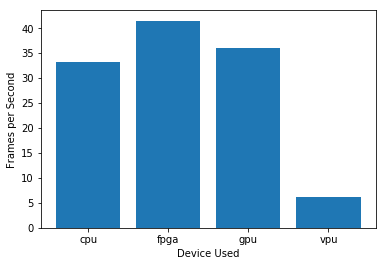

In [25]:
plt.bar(device_list, fps)
plt.xlabel("Device Used")
plt.ylabel("Frames per Second")
plt.show()

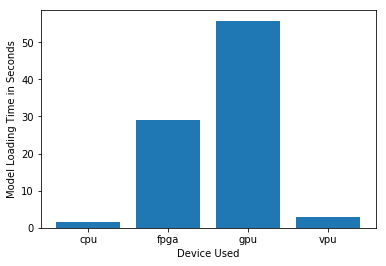

In [26]:
plt.bar(device_list, model_load_time)
plt.xlabel("Device Used")
plt.ylabel("Model Loading Time in Seconds")
plt.show()

# Step 3: Update Proposal Document

Now that you've completed your hardware testing, you should go back to the proposal document and validate or update your originally proposed hardware. Once you've updated your proposal, you can move onto the next scenario.